# Advantages of applying PCA on data for classification

One of the most important applications of PCA is for speeding up machine learning algorithms. The MNIST database of handwritten digits is more suitable as it has 784 feature columns (784 dimensions).

## Download the Data
You can also add a data_home parameter to fetch_mldata to change where you download the data.

In [1]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

The images that you downloaded are contained in mnist.data and has a shape of (70000, 784) meaning there are 70,000 images with 784 dimensions (784 features).

The labels (the integers 0–9) are contained in mnist.target. The features are 784 dimensional (28 x 28 images) and the labels are simply numbers from 0–9.

## Split Data into Training and Test Sets
Typically the train test split is 80% training and 20% test. This gives a training set of 56,000 examples, and a test set of 14,000 examples.

In [2]:
from sklearn.model_selection import train_test_split

train_img, test_img, train_lbl, test_lbl = train_test_split(mnist.data, mnist.target, test_size=0.2, random_state=0)

print('The size of the training data set:', train_img.shape)
print('The size of the test data set:', test_img.shape)

The size of the training data set: (56000, 784)
The size of the test data set: (14000, 784)


## Standardize the Data
PCA is effected by scale so you need to scale the features in the data before applying it. You can transform the data onto unit scale (mean = 0 and variance = 1) which is a requirement for the optimal performance of some machine learning algorithms. StandardScaler helps standardize the dataset features. Note you fit on the training set and transform on the training and test set. 

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(train_img)
# Apply transform to both the training set and the test set.
scaling_train_img = scaler.transform(train_img)
scaling_test_img = scaler.transform(test_img)

## Import and apply PCA
The following code below aims to retained 90% of the variance. It means that pca algorithm chooses the minimum number of principal components such that 90% of the variance is retained.

Note: You can find out how many components PCA have been selected after fitting the model using ``pca.n_components_`` function:

In [4]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(0.9)

# Fitting PCA on the training set only
pca.fit(scaling_train_img)

pca.n_components_

235

In this case, 90% of the variance amounts to 235 principal components.

## Cumulative explained variance
An important part of using PCA in practice is the ability to estimate how many components are needed to describe the data. This can be determined by looking at the cumulative explained variance ratio as a function of the number of components whether by using raw or scaling data:

In [5]:
import numpy as np
import matplotlib.pyplot as plt

#Applying pca on Scaling train data
spca = PCA().fit(scaling_train_img)
#Applying pca on Raw train data
rpca = PCA().fit(train_img)

plt.figure(figsize=(15,8))
plt.plot(np.cumsum(spca.explained_variance_ratio_))
plt.plot(np.cumsum(rpca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.legend(['Scaling train data','Raw train data'])
plt.show()

<Figure size 1500x800 with 1 Axes>

## Image reconstruction from compressed representation
Indeed, PCA compresses high dimensional data to lower dimensional data. It can also take the compressed representation of the data (lower dimensional data) back to an approximation of the original high dimensional data. 

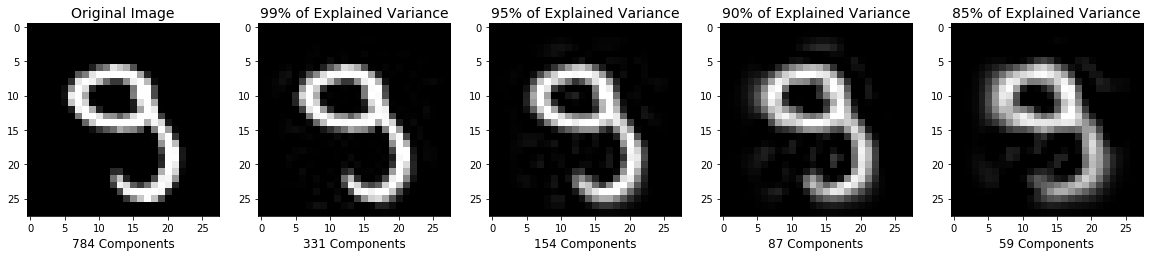

In [6]:
def compressedImage(percentage, images): 
    # percentage should be a decimal from 0 to 1 
    pca = PCA(percentage)
    pca.fit(images)
    components = pca.transform(images)
    approxOriginal = pca.inverse_transform(components)
    return approxOriginal, pca.n_components_, 100*percentage

explainedVariance = [1, 0.99, 0.95, 0.9, 0.85]
image = 500

plt.figure(figsize=(20,4));
for i in range(len(explainedVariance)):
    plt.subplot(1, len(explainedVariance), i+1);
    if explainedVariance[i]==1:
        plt.imshow(train_img[image].reshape(28,28),
                   cmap = plt.cm.gray, interpolation='nearest',
                   clim=(0, 255));
        plt.xlabel("%d"% mnist.data.shape[1]+' Components', fontsize = 12)
        plt.title('Original Image', fontsize = 14)
    else: 
        compimage = compressedImage(explainedVariance[i], train_img)
        plt.imshow(compimage[0][image].reshape(28, 28),
                   cmap = plt.cm.gray, interpolation='nearest',
                   clim=(0, 255));
        plt.xlabel("%d"% compimage[1]+' Components', fontsize = 12)
        plt.title("%d"% compimage[2]+'% of Explained Variance', fontsize = 14)
plt.show()

## Timing of applying Logistic Regression to PCA-based transformed Scaling and Raw Data

The aim of this tutorial section was to show that you can use PCA to speed up the fitting of machine learning algorithms. The table below shows how long it took to fit logistic regression on my computer after applying PCA (retaining different amounts of variance each time).

In [7]:
from sklearn.linear_model import LogisticRegression
import pandas as pd
import time

def timingTable(table_columns, explainedVariance, train_data, test_data, train_lbl, test_lbl): 
    # Create table to compare the used metrics
    timing = pd.DataFrame(columns = table_columns)
    #index through explained variance
    row_index = 0
    for i in range(len(explainedVariance)):
        if explainedVariance[i]==1:
            t = time.process_time()
            logisticRegr = LogisticRegression(solver = 'lbfgs')
            logisticRegr.fit(train_data, train_lbl)
            accuracy = logisticRegr.score(test_data, test_lbl)
            elapsed_time = time.process_time() - t
            timing.loc[row_index, 'Explained Variance (%)'] = explainedVariance[i]*100
            timing.loc[row_index, 'Number of PCs'] = train_data.shape[1]
            timing.loc[row_index, 'Accuracy'] = accuracy
            timing.loc[row_index, 'Elapsed Time (s)'] = elapsed_time
            row_index+=1
        else:
            # Make an instance of the Model
            pca = PCA(explainedVariance[i])
            # Fitting PCA on the training set only
            pca.fit(train_data)
            t = time.process_time()
            logisticRegr = LogisticRegression(solver = 'lbfgs')
            logisticRegr.fit(pca.transform(train_data), train_lbl)
            accuracy = logisticRegr.score(pca.transform(test_data), test_lbl)
            elapsed_time = time.process_time() - t
            timing.loc[row_index, 'Explained Variance (%)'] = explainedVariance[i]*100
            timing.loc[row_index, 'Number of PCs'] = pca.n_components_
            timing.loc[row_index, 'Accuracy'] = accuracy
            timing.loc[row_index, 'Elapsed Time (s)'] = elapsed_time
            row_index+=1
    return timing

In [8]:
train_img, test_img, train_lbl, test_lbl = train_test_split(mnist.data, mnist.target, test_size=0.2, random_state=0)

table_columns = ['Explained Variance (%)', 'Number of PCs', 'Accuracy','Elapsed Time (s)']
explainedVariance = [1, 0.99, 0.95, 0.9, 0.85, 0.8]

timing_scaling = timingTable(table_columns, explainedVariance, scaling_train_img, scaling_test_img, train_lbl, test_lbl)
print('Results according to scaling data:')
timing_scaling

Results according to scaling data:


,Explained Variance (%),Number of PCs,Accuracy,Elapsed Time (s)
0,100,784,0.915857,230.281
1,99,541,0.917357,165.219
2,95,330,0.918429,103.391
3,90,235,0.917286,81.2031
4,85,183,0.916143,68.0781
5,80,147,0.913929,54.125


In [9]:
timing = timingTable(table_columns, explainedVariance, train_img, test_img, train_lbl, test_lbl)
print('Results according to raw data:')
timing

Results according to raw data:


,Explained Variance (%),Number of PCs,Accuracy,Elapsed Time (s)
0,100,784,0.913357,244.797
1,99,331,0.769214,106
2,95,154,0.914286,58.0469
3,90,87,0.909071,39.4062
4,85,59,0.903214,26.7031
5,80,43,0.893857,17.2188


As you can see, by reducing the selected number of principal components, the Logistic Regression machine learning algorithm is much faster. At the same time, its classification accuracy is sometimes better based on a reduced number of principal components.